# Subset 24 Model

**Table of Contents**
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In this Jupyter Notebook I train a model on a MobileNetV2 CNN and thereby extract the features of the different Phytoplankton. Instead of the blind split that was done in the previous attempt of version 1, here the split is made based on the extractable features. The goal is to train a model that is capable of identifying the most classes possible out of the 50. The model selected the remaining 24 classes (there is some overlap of 4 classes in the 2 version 2 models) out of the 50 classes and reaches an average weighted F1 Score of 85%

### Model Choice
A Convolutional Neural Network (CNN) is an ideal baseline model for classifying 50 types of phytoplankton images, as it excels in capturing the subtle variances in shape, size, and texture that are crucial for distinguishing between different phytoplankton types. With its robustness to image variations and effectiveness in complex multi-class tasks, a CNN is highly suitable for this purpose. Moreover, its scalability and the potential for transfer learning add to its practicality in handling diverse datasets. Importantly, a CNN serves as an excellent starting point for model optimization, where further improvements can be achieved by fine-tuning hyperparameters and experimenting with various preprocessing techniques, allowing for tailored enhancements to suit specific dataset characteristics.

In [1]:
from google.colab import files, drive
import zipfile
import shutil
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, Conv2D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from collections import Counter
import random
from matplotlib.backends.backend_pdf import PdfPages
import glob
import nbformat as nbf
from nbformat.v4 import new_markdown_cell, new_code_cell, new_output
import json

In [2]:
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/ML_Tensorflow/phytoplankton_labeled.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

data_dir = '/content/dataset/labeled_20201020'

base_dir = '/content/dataset'

Mounted at /content/drive


In [3]:
def prepare_data_for_class_range(class_range, class_to_idx):
    # Filter the paths and labels for the selected classes
    start_class, end_class = class_range
    filtered_image_paths = [path for path, label in zip(image_paths, labels) if class_to_idx[label] in range(start_class, end_class + 1)]
    filtered_labels = [label for label in labels if class_to_idx[label] in range(start_class, end_class + 1)]

    # Split the filtered dataset into train, val, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(filtered_image_paths, filtered_labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

    # Define directories for train, val, test
    train_dir = os.path.join(base_dir, f'train_directory_{start_class}_{end_class}')
    val_dir = os.path.join(base_dir, f'val_directory_{start_class}_{end_class}')
    test_dir = os.path.join(base_dir, f'test_directory_{start_class}_{end_class}')

    # Remove existing directories and recreate them
    for dir in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

    # Function to create directories and copy images
    def create_and_copy(image_paths, labels, target_dir):
        for img_path, label in zip(image_paths, labels):
            class_dir = os.path.join(target_dir, label)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            shutil.copy(img_path, os.path.join(class_dir, os.path.basename(img_path)))

    # Copy files to their respective directories
    create_and_copy(X_train, y_train, train_dir)
    create_and_copy(X_val, y_val, val_dir)
    create_and_copy(X_test, y_test, test_dir)

    return train_dir, val_dir, test_dir

# Specify the number of classes to include
num_classes = 50
batch_size = 16

# Get paths and labels for a subset of classes
image_paths = []
labels = []
for class_dir in sorted(os.listdir(data_dir)):
    class_dir_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_dir_path):
        image_paths.extend([os.path.join(class_dir_path, image) for image in os.listdir(class_dir_path)])
        labels.extend([class_dir] * len(os.listdir(class_dir_path)))

# Select the first 'num_classes' classes
unique_classes = np.unique(labels)
selected_classes = set(unique_classes[:num_classes])

# Generate a dictionary mapping numerical values to class names
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_classes)}

# Generate a dictionary mapping numerical values back to class names
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Define the class range
# class_ranges = [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]
class_ranges = [(0, 49)]

# Print completion message
for class_range in class_ranges:
    train_dir, val_dir, test_dir = prepare_data_for_class_range(class_range, class_to_idx)
    print(f"Data for classes {class_range} prepared and stored in:\nTrain: {train_dir}\nVal: {val_dir}\nTest: {test_dir}")


Data for classes (0, 49) prepared and stored in:
Train: /content/dataset/train_directory_0_49
Val: /content/dataset/val_directory_0_49
Test: /content/dataset/test_directory_0_49


In [4]:
# Undersampling overrepresented classes
desired_count = 25
epochs = 5

def undersample_training_directories(class_ranges):
    class_counts = {}

    for class_range in class_ranges:
        train_dir = os.path.join(base_dir, f'train_directory_{class_range[0]}_{class_range[1]}')

        for class_dir in os.listdir(train_dir):
            class_dir_path = os.path.join(train_dir, class_dir)
            if os.path.isdir(class_dir_path):
                images = os.listdir(class_dir_path)
                if len(images) > desired_count:
                    # Randomly select and remove images
                    images_to_remove = random.sample(images, len(images) - desired_count)
                    for image in images_to_remove:
                        os.remove(os.path.join(class_dir_path, image))

                # Update class_counts dictionary
                class_counts[class_dir] = len(os.listdir(class_dir_path))

    return class_counts

class_counts = undersample_training_directories(class_ranges)
print(class_counts)

{'Monoraphidium_contortum': 25, 'Heterocapsa_rotundata': 25, 'Gymnodiniales': 25, 'Chroococcales': 25, 'Katablepharis_remigera': 25, 'Dinophyceae': 25, 'Pennales_sp_thick': 25, 'Centrales_sp': 25, 'Chroococcus_small': 25, 'Cryptomonadales': 25, 'Melosira_arctica': 25, 'Thalassiosira_levanderi': 25, 'Licmophora_sp': 25, 'Chlorococcales': 25, 'Cryptophyceae-Teleaulax': 25, 'Aphanothece_paralleliformis': 23, 'Dolichospermum-Anabaenopsis-coiled': 25, 'Peridiniella_catenata_chain': 25, 'Skeletonema_marinoi': 25, 'Chaetoceros_sp': 25, 'Eutreptiella_sp': 25, 'Heterocyte': 25, 'Nitzschia_paleacea': 25, 'Prorocentrum_cordatum': 25, 'Pseudopedinella_sp': 25, 'Heterocapsa_triquetra': 25, 'Peridiniella_catenata_single': 25, 'Snowella-Woronichinia': 25, 'Cymbomonas_tetramitiformis': 25, 'Oocystis_sp': 25, 'Oscillatoriales': 25, 'Beads': 25, 'Ciliata': 25, 'Gymnodinium_like': 25, 'Aphanizomenon_flosaquae': 25, 'Dolichospermum-Anabaenopsis': 25, 'Mesodinium_rubrum': 25, 'Amylax_triacantha': 16, 'Gony

### Feature Selection

In the context of using a Convolutional Neural Network (CNN) for classifying images of phytoplankton, "feature selection" takes on a different meaning compared to traditional machine learning models. Unlike models where you manually select features from a dataset, CNNs handle feature extraction and selection internally through their layers.

### Implementation

This CNN model, with its multiple convolutional and pooling layers followed by fully connected layers, is designed to effectively capture the hierarchical features in the phytoplankton images, making it suitable for the classification task at hand. The use of ReLU and softmax activations, along with the adam optimizer and categorical crossentropy loss, aligns well with the needs of a complex image classification challenge.

Found 12615 images belonging to 50 classes.
Found 6308 images belonging to 50 classes.
9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 50

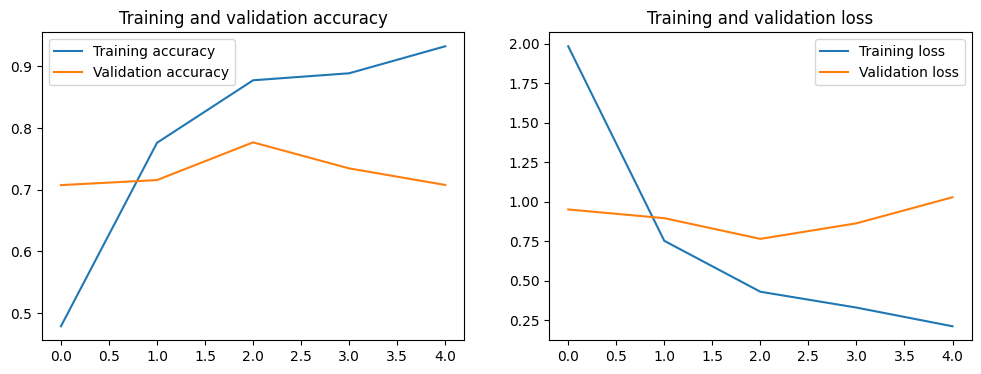

395/395 [==============================] - 71s 179ms/step - loss: 1.0251 - accuracy: 0.7091
Test Accuracy for classes (0, 49): 0.709099531173706


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
def create_model(num_classes):
    # Load MobileNetV2 pre-trained on ImageNet data
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    base_model.trainable = False  # Freeze the base model

    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to return augmented data generator for underrepresented classes
def get_augmentation():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

# Define a custom generator
def custom_generator(train_dir, batch_size, class_counts, desired_count):
    base_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )
    while True:
        x_batch, y_batch = next(base_generator)
        for i in range(x_batch.shape[0]):
            class_index = np.argmax(y_batch[i])
            class_name = list(base_generator.class_indices.keys())[class_index]
            if class_counts[class_name] < desired_count:
                aug_gen = get_augmentation()
                x_batch[i] = aug_gen.random_transform(x_batch[i])
        yield x_batch, y_batch

def create_data_generators(train_dir, val_dir, test_dir, batch_size, class_counts, desired_count):
    train_generator = custom_generator(train_dir, batch_size, class_counts, desired_count)

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

for class_range in class_ranges:
    train_dir = f'/content/dataset/train_directory_{class_range[0]}_{class_range[1]}'
    val_dir = f'/content/dataset/val_directory_{class_range[0]}_{class_range[1]}'
    test_dir = f'/content/dataset/test_directory_{class_range[0]}_{class_range[1]}'

    # Create data generators
    train_generator, val_generator, test_generator = create_data_generators(
        train_dir, val_dir, test_dir, batch_size, class_counts, desired_count
    )

    # Create a new model for the current subset of classes
    num_classes = class_range[1] - class_range[0] + 1
    model = create_model(num_classes)
    model.summary()

    # Calculate the number of training samples for the current class range
    current_range_counts = {k: v for k, v in class_counts.items() if class_to_idx[k] in range(class_range[0], class_range[1] + 1)}
    num_train_samples = sum(current_range_counts.values())

    # Calculate steps per epoch for the current class range
    steps_per_epoch = np.ceil(num_train_samples / batch_size)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batch_size)
    )

    # Convert the training history into a dictionary
    history_dict = history.history

    # Serialize the dictionary into JSON
    history_json = json.dumps(history_dict, indent=4)

    # Specify the directory to save the history
    history_save_dir = f'/content/drive/MyDrive/ML_Tensorflow/training_history{class_range}_1.json'

    # Write the JSON data to a file
    with open(history_save_dir, 'w') as f:
        f.write(history_json)

    print(f"Saved the training history to {history_save_dir}")

    # Plot the training history
    plot_training_history(history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy for classes {class_range}: {test_accuracy}")

    model_save_dir = f'/content/drive/MyDrive/ML_Tensorflow/test_model_{class_range[0]}_{class_range[1]}_1.h5'

    # Save the model for future use
    model.save(model_save_dir)

## Evaluation

1. Accuracy: This metric gives you a straightforward indication of the overall correctness of the model by showing the proportion of correct predictions out of all predictions. It's a useful initial indicator to see how well the model performs across all classes.

2. Confusion Matrix: This tool is particularly valuable in multi-class classification problems like your 50 phytoplankton types. It not only shows the overall performance but also breaks it down into each class, revealing how the model confuses between different types of phytoplankton. It can highlight if the model is particularly good or bad at classifying certain classes, which is critical information for fine-tuning.

Found 6308 images belonging to 50 classes.
395/395 [==============================] - 74s 187ms/step
Accuracy for classes (0, 49): 0.7090995561192137


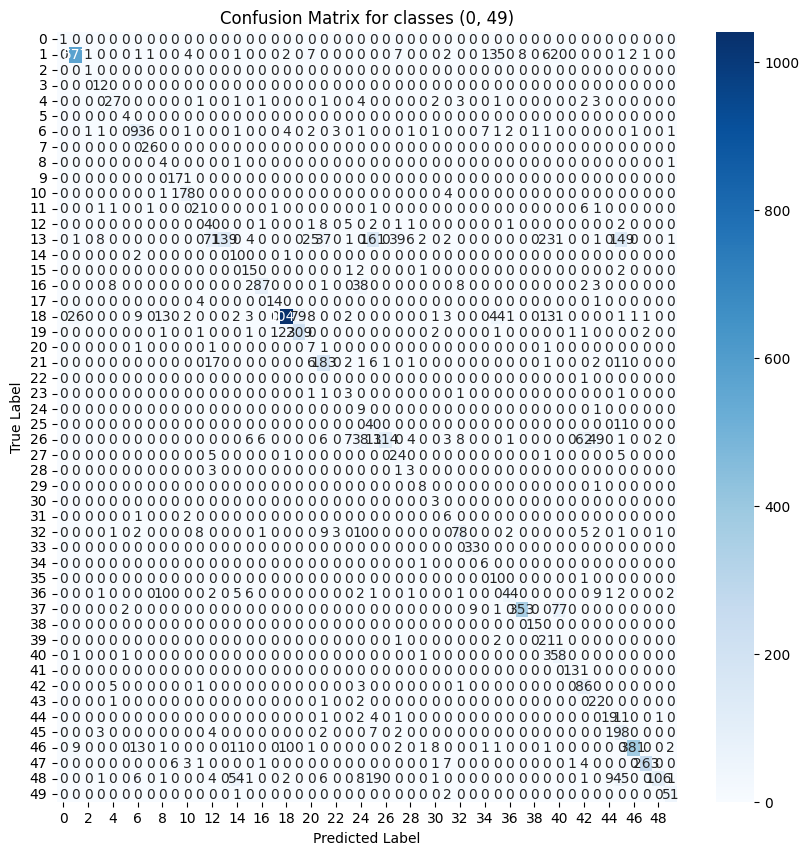

                                    precision    recall  f1-score   support

                 Amylax_triacantha       1.00      1.00      1.00         1
           Aphanizomenon_flosaquae       0.94      0.85      0.89       677
       Aphanothece_paralleliformis       0.33      1.00      0.50         1
                             Beads       0.44      1.00      0.62        12
                      Centrales_sp       0.63      0.59      0.61        46
             Ceratoneis_closterium       0.57      1.00      0.73         4
                    Chaetoceros_sp       0.73      0.72      0.72       129
             Chaetoceros_sp_single       0.76      1.00      0.87        26
                    Chlorococcales       0.13      0.67      0.22         6
                     Chroococcales       0.71      0.94      0.81        18
                 Chroococcus_small       0.86      0.93      0.89        84
                           Ciliata       0.57      0.64      0.60        33
           

In [6]:
def create_test_generator(test_dir, batch_size):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return test_generator

for class_range in class_ranges:
    model_dir = model_save_dir
    model = load_model(model_dir)

    # Ensure your test_generator is set correctly for the current model
    test_dir = f'/content/dataset/test_directory_{class_range[0]}_{class_range[1]}'
    test_generator = create_test_generator(test_dir, batch_size)

    test_generator.shuffle = False
    test_generator.reset()

    # Predict using the model
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

    # Convert predictions to class indices
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Get true labels from the generator
    true_labels = test_generator.classes

    # Calculate accuracy
    accuracy = np.sum(predicted_class_indices == true_labels) / len(true_labels)
    print(f"Accuracy for classes {class_range}: {accuracy}")

    # Generate and plot the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_class_indices)

    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for classes {class_range}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  # Display the figure
    plt.close()

    # Print classification report
    cr = classification_report(true_labels, predicted_class_indices, target_names=list(test_generator.class_indices.keys()))
    print(cr)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy for classes {class_range}: {test_accuracy}")


In [7]:
cr = classification_report(true_labels, predicted_class_indices, target_names=list(test_generator.class_indices.keys()))
print(cr)

                                    precision    recall  f1-score   support

                 Amylax_triacantha       1.00      1.00      1.00         1
           Aphanizomenon_flosaquae       0.94      0.85      0.89       677
       Aphanothece_paralleliformis       0.33      1.00      0.50         1
                             Beads       0.44      1.00      0.62        12
                      Centrales_sp       0.63      0.59      0.61        46
             Ceratoneis_closterium       0.57      1.00      0.73         4
                    Chaetoceros_sp       0.73      0.72      0.72       129
             Chaetoceros_sp_single       0.76      1.00      0.87        26
                    Chlorococcales       0.13      0.67      0.22         6
                     Chroococcales       0.71      0.94      0.81        18
                 Chroococcus_small       0.86      0.93      0.89        84
                           Ciliata       0.57      0.64      0.60        33
           

In [10]:
import re

# Define threshold value
f1_min = 0.60

# Create empty list to store class names meeting criteria
classes_above_f1_min = []

# Iterate through classification report lines
lines = cr.split('\n')

for line in lines[2:-3]: # Skip header and summary rows
    # Using regular expression to find alphanumeric parts including "."
    # row = re.findall(r'\w+\.?\w*', line)
    row = re.findall(r'[\w.-]+', line)
    if (len(row) > 3):
      if float(row[3]) < f1_min: # Check if F1 Score exceeds minimum
        classes_above_f1_min.append(row[0]) # Add class name to list

num_classes_filtered = len(classes_above_f1_min)

# Print results
print("Classes with F1 Scores < " + str(f1_min) + "; # =", num_classes_filtered)
print(*classes_above_f1_min, sep='\n')

Classes with F1 Scores < 0.6; # = 24
Aphanothece_paralleliformis
Chlorococcales
Cryptomonadales
Cryptophyceae-Teleaulax
Cyclotella_choctawhatcheeana
Cymbomonas_tetramitiformis
Euglenophyceae
Gonyaulax_verior
Gymnodiniales
Gymnodinium_like
Heterocapsa_rotundata
Heterocapsa_triquetra
Heterocyte
Katablepharis_remigera
Melosira_arctica
Merismopedia_sp
Nitzschia_paleacea
Nodularia_spumigena
Pennales_sp_thick
Pennales_sp_thin
Prorocentrum_cordatum
Pseudopedinella_sp
Pyramimonas_sp
Thalassiosira_levanderi


In [14]:
# Print completion message
for class_range in class_ranges:
    train_dir, val_dir, test_dir = prepare_data_for_class_range(class_range, class_to_idx)
    print(f"Data for classes {class_range} prepared and stored in:\nTrain: {train_dir}\nVal: {val_dir}\nTest: {test_dir}")

# Undersampling overrepresented classes
desired_count = 250
epochs = 12

def undersample_training_directories(class_ranges):
    class_counts = {}

    for class_range in class_ranges:
        train_dir = os.path.join(base_dir, f'train_directory_{class_range[0]}_{class_range[1]}')

        for class_dir in os.listdir(train_dir):
            class_dir_path = os.path.join(train_dir, class_dir)
            if os.path.isdir(class_dir_path):
                images = os.listdir(class_dir_path)
                if len(images) > desired_count:
                    # Randomly select and remove images
                    images_to_remove = random.sample(images, len(images) - desired_count)
                    for image in images_to_remove:
                        os.remove(os.path.join(class_dir_path, image))

                # Update class_counts dictionary
                class_counts[class_dir] = len(os.listdir(class_dir_path))

    return class_counts

class_counts = undersample_training_directories(class_ranges)
print(class_counts)

Data for classes (0, 49) prepared and stored in:
Train: /content/dataset/train_directory_0_49
Val: /content/dataset/val_directory_0_49
Test: /content/dataset/test_directory_0_49
{'Monoraphidium_contortum': 229, 'Heterocapsa_rotundata': 250, 'Gymnodiniales': 48, 'Chroococcales': 102, 'Katablepharis_remigera': 33, 'Dinophyceae': 250, 'Pennales_sp_thick': 143, 'Centrales_sp': 250, 'Chroococcus_small': 250, 'Cryptomonadales': 250, 'Melosira_arctica': 29, 'Thalassiosira_levanderi': 250, 'Licmophora_sp': 51, 'Chlorococcales': 69, 'Cryptophyceae-Teleaulax': 250, 'Aphanothece_paralleliformis': 23, 'Dolichospermum-Anabaenopsis-coiled': 250, 'Peridiniella_catenata_chain': 138, 'Skeletonema_marinoi': 250, 'Chaetoceros_sp': 250, 'Eutreptiella_sp': 250, 'Heterocyte': 173, 'Nitzschia_paleacea': 50, 'Prorocentrum_cordatum': 186, 'Pseudopedinella_sp': 250, 'Heterocapsa_triquetra': 250, 'Peridiniella_catenata_single': 250, 'Snowella-Woronichinia': 250, 'Cymbomonas_tetramitiformis': 135, 'Oocystis_sp': 

In [15]:
# Create new directories
for directory_type in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_dir, f"{directory_type}_directory_filtered"), exist_ok=True)

# Copy selected classes to new directories
for selected_class in classes_above_f1_min:
    for directory_type in ["train", "val", "test"]:
        source_dir_1 = os.path.join(base_dir, f"{directory_type}_directory_0_49", selected_class)
        dest_dir_1 = os.path.join(base_dir, f"{directory_type}_directory_filtered", selected_class)
        if not os.path.exists(dest_dir_1):
            shutil.copytree(source_dir_1, dest_dir_1)
        else:
            print(f"Directory '{dest_dir_1}' already exists. Skipping.")

print("Copying completed.")
print("Found ", len(os.listdir(base_dir + "/val_directory_filtered")), " classes.")
if (len(os.listdir(base_dir + "/val_directory_filtered")) != num_classes_filtered):
  print("ERROR! MISMATCH OF CLASSES!")

Directory '/content/dataset/train_directory_filtered/Aphanothece_paralleliformis' already exists. Skipping.
Directory '/content/dataset/val_directory_filtered/Aphanothece_paralleliformis' already exists. Skipping.
Directory '/content/dataset/test_directory_filtered/Aphanothece_paralleliformis' already exists. Skipping.
Directory '/content/dataset/train_directory_filtered/Chlorococcales' already exists. Skipping.
Directory '/content/dataset/val_directory_filtered/Chlorococcales' already exists. Skipping.
Directory '/content/dataset/test_directory_filtered/Chlorococcales' already exists. Skipping.
Directory '/content/dataset/train_directory_filtered/Cryptomonadales' already exists. Skipping.
Directory '/content/dataset/val_directory_filtered/Cryptomonadales' already exists. Skipping.
Directory '/content/dataset/test_directory_filtered/Cryptomonadales' already exists. Skipping.
Directory '/content/dataset/train_directory_filtered/Cryptophyceae-Teleaulax' already exists. Skipping.
Director

Found 3735 images belonging to 24 classes.
Found 1783 images belonging to 24 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 24)                24600     
                                  

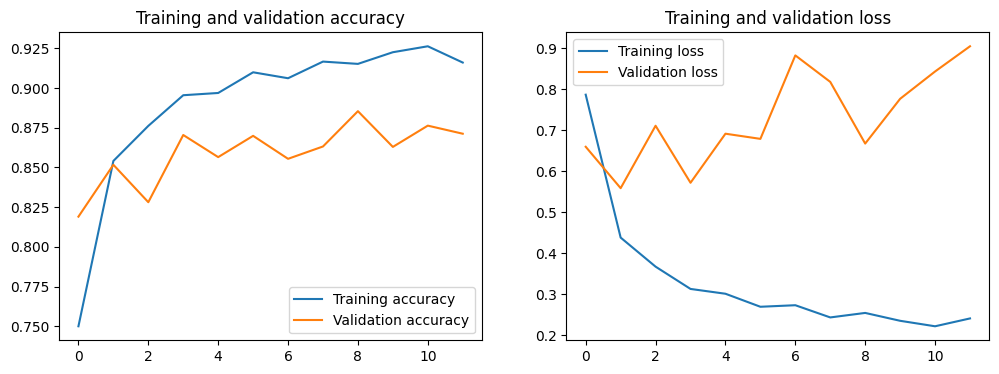

112/112 [==============================] - 18s 164ms/step - loss: 0.8827 - accuracy: 0.8654
Test Accuracy for classes (0, 49): 0.8653954267501831


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
for class_range in class_ranges:
    train_dir = f'/content/dataset/train_directory_filtered'
    val_dir = f'/content/dataset/val_directory_filtered'
    test_dir = f'/content/dataset/test_directory_filtered'

    # Create data generators
    train_generator, val_generator, test_generator = create_data_generators(
        train_dir, val_dir, test_dir, batch_size, class_counts, desired_count
    )

    # Create a new model for the current subset of classes
    model_filtered = create_model(num_classes_filtered)
    model_filtered.summary()

    # Calculate the number of training samples for the current class range
    current_range_counts = {k: v for k, v in class_counts.items() if class_to_idx[k] in range(class_range[0], class_range[1] + 1)}
    num_train_samples = sum(current_range_counts.values())

    # Calculate steps per epoch for the current class range
    steps_per_epoch = np.ceil(num_train_samples / batch_size)

    # Train the model
    history_filtered = model_filtered.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=np.ceil(val_generator.samples / batch_size)
    )

    # Convert the training history into a dictionary
    history_dict = history_filtered.history

    # Serialize the dictionary into JSON
    history_json = json.dumps(history_dict, indent=4)

    # Specify the directory to save the history
    history_save_dir = f'/content/drive/MyDrive/ML_Tensorflow/training_history{class_range}_filtered_3.json'

    # Write the JSON data to a file
    with open(history_save_dir, 'w') as f:
        f.write(history_json)

    print(f"Saved the training history to {history_save_dir}")

    # Plot the training history
    plot_training_history(history_filtered)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model_filtered.evaluate(test_generator)
    print(f"Test Accuracy for classes {class_range}: {test_accuracy}")

    model_save_dir = f'/content/drive/MyDrive/ML_Tensorflow/test_model_{class_range[0]}_{class_range[1]}_filtered_3.h5'

    # Save the model for future use
    model_filtered.save(model_save_dir)

Found 1783 images belonging to 24 classes.
112/112 [==============================] - 19s 166ms/step
Accuracy for classes (0, 49): 0.8653954010095345


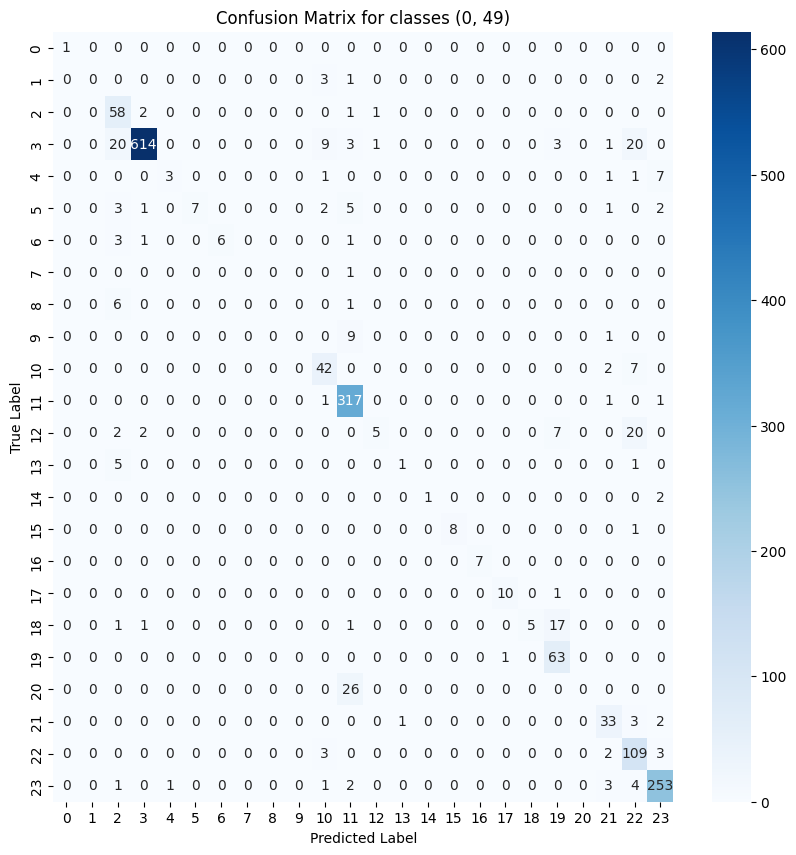

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

 Aphanothece_paralleliformis       1.00      1.00      1.00         1
              Chlorococcales       0.00      0.00      0.00         6
             Cryptomonadales       0.59      0.94      0.72        62
     Cryptophyceae-Teleaulax       0.99      0.92      0.95       671
Cyclotella_choctawhatcheeana       0.75      0.23      0.35        13
  Cymbomonas_tetramitiformis       1.00      0.33      0.50        21
              Euglenophyceae       1.00      0.55      0.71        11
            Gonyaulax_verior       0.00      0.00      0.00         1
               Gymnodiniales       0.00      0.00      0.00         7
            Gymnodinium_like       0.00      0.00      0.00        10
       Heterocapsa_rotundata       0.68      0.82      0.74        51
       Heterocapsa_triquetra       0.86      0.99      0.92       320
                  Heterocyte       0.71      0.14      0.23        36
      Katablepharis

In [17]:
for class_range in class_ranges:
    model_dir = model_save_dir
    model = load_model(model_dir)

    # Ensure your test_generator is set correctly for the current model
    test_dir = f'/content/dataset/test_directory_filtered'
    test_generator = create_test_generator(test_dir, batch_size)

    test_generator.shuffle = False
    test_generator.reset()

    # Predict using the model
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

    # Convert predictions to class indices
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Get true labels from the generator
    true_labels = test_generator.classes

    # Calculate accuracy
    accuracy = np.sum(predicted_class_indices == true_labels) / len(true_labels)
    print(f"Accuracy for classes {class_range}: {accuracy}")

    # Generate and plot the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_class_indices)

    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for classes {class_range}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  # Display the figure
    plt.close()

    # Print classification report
    cr = classification_report(true_labels, predicted_class_indices, target_names=list(test_generator.class_indices.keys()))
    print(cr)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy for classes {class_range}: {test_accuracy}")